In [65]:
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

from qutip import *
from qutip.control import *
from qutip.qip.operations import rx
from qutip.qip.operations import ry
from qutip.qip.operations import rz

from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from dataclasses import dataclass
from typing import List, Tuple, Sequence

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.express as px

from scipy.constants import physical_constants, h

from qutip import jmat, tensor, identity, Qobj

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_bloch_multivector

import numpy as np

# Finding Pulse Sequence

### Setting beginning and ending states
### setting desired U value

In [66]:
qubit1state=basis(3, 0)
qubit2state=basis(3, 0)
startingstate=tensor(qubit1state,qubit1state) #initial state
endingstate= tensor(basis(3,0),basis(3,2))
startingstate.dims=[[9],[1]]
endingstate.dims=[[9],[1]]
print (startingstate)
print (endingstate)


U=tensor(rotation (jmat(1,'x'),pi),identity(3))

U.dims=[[9],[9]]
U



Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


C:\Users\RA\AppData\Local\Temp\ipykernel_15076\1588627107.py:11: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U=tensor(rotation (jmat(1,'x'),pi),identity(3))


Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 0.5+0.j          0. +0.j          0. +0.j          0. -0.70710678j
   0. +0.j          0. +0.j         -0.5+0.j          0. +0.j
   0. +0.j        ]
 [ 0. +0.j          0.5+0.j          0. +0.j          0. +0.j
   0. -0.70710678j  0. +0.j          0. +0.j         -0.5+0.j
   0. +0.j        ]
 [ 0. +0.j          0. +0.j          0.5+0.j          0. +0.j
   0. +0.j          0. -0.70710678j  0. +0.j          0. +0.j
  -0.5+0.j        ]
 [ 0. -0.70710678j  0. +0.j          0. +0.j          0. +0.j
   0. +0.j          0. +0.j          0. -0.70710678j  0. +0.j
   0. +0.j        ]
 [ 0. +0.j          0. -0.70710678j  0. +0.j          0. +0.j
   0. +0.j          0. +0.j          0. +0.j          0. -0.70710678j
   0. +0.j        ]
 [ 0. +0.j          0. +0.j          0. -0.70710678j  0. +0.j
   0. +0.j          0. +0.j          0. +0.j          0. +0.j
   0. -0.70710678j]
 [-0.5+0.j          0. +0.j  

## Defining 3x3 pauli spin matrices 
## Definiting number of iterations
## Defining H_ops

In [67]:
#defining constants in hamiltonian
h= 6.582119 * 1e-16 #eV * sec 
Bperpendicular = 10 #mT
Bparallel = 10 #mT
gammanv = 2*np.pi*28 * 1000000 #Hz/mT
omeganv = Bparallel * gammanv
omegamw = 1000000000 #Hz
Delta = omeganv - omegamw
#Delta
Omega = Bperpendicular * gammanv
Omega

T = 10/Omega
steps=100
times = np.linspace(0, T, steps)

In [68]:


#wirting our terms so I can actually read the hamiltonian
#Nuc terms are second qubit
#Elec qubit is first qubit

nuclear_spin = 1
electron_spin = 1
sigmaxE = jmat(electron_spin,'x')
sigmayE = jmat(electron_spin,'y')
sigmazE = jmat(electron_spin,'z')
sigmaxN = jmat(nuclear_spin,'x')
sigmayN = jmat(nuclear_spin,'y')
sigmazN = jmat(nuclear_spin,'z')
sigmazEsquared = sigmazE*sigmazE
sigmazNsquared = sigmazN*sigmazN
identity3 = identity(3) #3x3 identity matrix



#Creating operators that can be tuned in the Hamiltonian via the control fields, list is below called H_ops

H_opsEx=tensor(sigmaxE, identity3)
H_opsEy=tensor(sigmayE, identity3)
H_opsEz=tensor(sigmazE, identity3)

H_opsNx=tensor(identity3, sigmaxN)
H_opsNy=tensor(identity3, sigmayN)
H_opsNz=tensor(identity3, sigmazN)

H_opsENx = tensor(sigmaxE, sigmaxN)
H_opsENy = tensor(sigmayE, sigmayN)           
H_opsENz = tensor(sigmazE, sigmazN)
#print (H_opsENz)

#changing dims bc qutip is silly

H_opsEx.dims=[[9],[9]]
H_opsEy.dims=[[9],[9]]
H_opsEz.dims=[[9],[9]]

H_opsNx.dims=[[9],[9]]
H_opsNy.dims=[[9],[9]]
H_opsNz.dims=[[9],[9]]

H_opsENx.dims=[[9],[9]]
H_opsENy.dims=[[9],[9]]
H_opsENz.dims=[[9],[9]] 


#making H_ops list           
H_ops = [H_opsEx*Omega, H_opsEy*Omega]#, H_opsEz, H_opsNx, H_opsNy, H_opsNz, H_opsENx, H_opsENy, H_opsENz]            
               
               
#making labels for pulse sequence graphs
H_labels = [r'$uE_{x}$',
            r'$uE_{y}$']
            #r'$uE_{z}$',
            #r'$uN_{x}$',
            ##r'$uN_{y}$',
            #r'$uN_{z}$',
           # r'$uEN_{x}$',
           # r'$uEN_{y}$',
            #r'$uEN_{z}$']


# Defining hamiltonian and constants 

In [69]:
#defining hamiltonian for NV center

#constants

f_fine_structure = 2.87e9
f_nuclear_quadrupole = -5.01e6
f_axial_magnetic_hyperfine = -2.14e6
f_transverse_magnetic_hyperfine = -2.7e6
g_factor_electron = 2.0028
gyromagnetic_constant_nuclear = 1.93297e7 / (2 * np.pi)
uB = physical_constants['Bohr magneton'][0]
uN = physical_constants['nuclear magneton'][0]    
bvector=[0,0,1]


#witing out hamiltonian terms

H1 = f_fine_structure * tensor((sigmazEsquared-(2/3)*identity3),identity3)

H2 = f_axial_magnetic_hyperfine * tensor(sigmazE,sigmazN) 

H3 = f_transverse_magnetic_hyperfine * (tensor(sigmaxE,sigmaxN)+tensor(sigmayE,sigmayN))

H4 = f_nuclear_quadrupole * tensor(tensor(identity3), (sigmazNsquared-(2/3)*identity3))

#H5 = ((uB/h) * g_factor_electron) * tensor((sigmaxE*bvector[0] + sigmayE*bvector[1] + sigmazE*bvector[2]), identity3)

#H6 = gyromagnetic_constant_nuclear * tensor(identity3,(sigmaxN*bvector[0] + sigmayN*bvector[1] + sigmazN*bvector[2]))
          
    
H0= H1+H2 +H3 +H4 #+H5 +H6
H0.dims=[[9],[9]] #changing dimensions bc dot products are silly
H0 #hamiltonian without b field term



Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 9.52856667e+08  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  9.60006667e+08  0.00000000e+00 -2.70000000e+06
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  9.57136667e+08  0.00000000e+00
  -2.70000000e+06  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -2.70000000e+06  0.00000000e+00 -1.91500333e+09
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.70000000e+06  0.00000000e+00
  -1.90999333e+09  0.00000000e+00 -2.70000000e+06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.91500333e+09  0.00000000e+00 -2.70000000e+06
   0.00000000e+00]
 [ 0

# Plot pulses

In [70]:


##creating initial control pulse values as starting guess for GRAPE

u0 = np.array([np.random.rand(len(times))*T * 2 * pi * 0.005 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10) / 10, u0[idx, :], mode='same') for idx in range(len(H_ops))]


In [71]:
#doing GRAPE!
R=1000
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2 * pi / T, phase_sensitive=False,
                          progress_bar=TextProgressBar())



10.0%. Run time:  33.33s. Est. time left: 00:00:04:59
20.0%. Run time:  69.53s. Est. time left: 00:00:04:38
30.0%. Run time: 101.27s. Est. time left: 00:00:03:56
40.0%. Run time: 132.96s. Est. time left: 00:00:03:19
50.0%. Run time: 164.45s. Est. time left: 00:00:02:44
60.0%. Run time: 196.41s. Est. time left: 00:00:02:10
70.0%. Run time: 227.88s. Est. time left: 00:00:01:37
80.0%. Run time: 259.48s. Est. time left: 00:00:01:04
90.0%. Run time: 291.17s. Est. time left: 00:00:00:32
Total run time: 322.71s


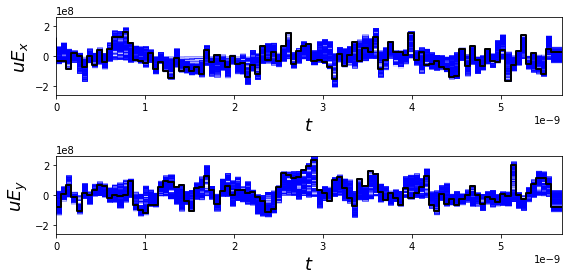

In [72]:
plot_grape_control_fields(times, result.u[:, :, :] / (2 * pi), H_labels, uniform_axes=True);
plt.show()

# Calcuate fidelity

In [73]:
idealfinalstate=U*startingstate
print (idealfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[ 0.5+0.j        ]
 [ 0. +0.j        ]
 [ 0. +0.j        ]
 [ 0. -0.70710678j]
 [ 0. +0.j        ]
 [ 0. +0.j        ]
 [-0.5+0.j        ]
 [ 0. +0.j        ]
 [ 0. +0.j        ]]


In [74]:
result.U_f.tidyup(1e-2)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[-0.45858551-0.09894628j  0.        +0.j          0.        +0.j
   0.30798094+0.68206557j  0.        +0.j          0.        +0.j
   0.24162637-0.40181971j  0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.46121727-0.08584883j  0.        +0.j
   0.        +0.j          0.32727744+0.67301835j  0.        +0.j
   0.        +0.j          0.23008624-0.40853654j  0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.45858641-0.09894617j
   0.        +0.j          0.        +0.j          0.30798147+0.68206436j
   0.        +0.j          0.        +0.j          0.24162574-0.40181951j]
 [ 0.20926788-0.48810909j  0.        +0.j          0.        +0.j
  -0.16303389+0.09790515j  0.        +0.j          0.        +0.j
  -0.6711456 -0.48099038j  0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.19528419-0.49386945j  0.        +0.j

In [75]:
realfinalstate=result.U_f*startingstate
print (realfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[-0.45858551-0.09894628j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.20926788-0.48810909j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.10157974+0.69824438j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]]


In [76]:
idealdensitymatrix=(idealfinalstate * idealfinalstate.dag())#ideal density matrix
densitymatrix=(realfinalstate * realfinalstate.dag())# real density matrix
print (idealdensitymatrix)
print (densitymatrix)
fidelity(idealdensitymatrix,densitymatrix)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 0.25+0.j          0.  +0.j          0.  +0.j          0.  +0.35355339j
   0.  +0.j          0.  +0.j         -0.25+0.j          0.  +0.j
   0.  +0.j        ]
 [ 0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j        ]
 [ 0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j        ]
 [ 0.  -0.35355339j  0.  +0.j          0.  +0.j          0.5 +0.j
   0.  +0.j          0.  +0.j          0.  +0.35355339j  0.  +0.j
   0.  +0.j        ]
 [ 0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j        ]
 [ 0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.

0.25892822567845075

# Plotting City Scape


In [38]:
#plotting cityscape for real density matrix
dm=np.array(densitymatrix)
print (dm)
plot_state_city(dm, title='State Tomography for Real State')

[[0.99999992+0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j]
 [0.  

VisualizationError: 'Input is not a multi-qubit quantum state.'

In [39]:
#plotting cityscape for ideal density matrix
idm=np.array(idealdensitymatrix)
print (idm)
plot_state_city(idm, title='State Tomography for Ideal State')

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


VisualizationError: 'Input is not a multi-qubit quantum state.'